# Project 4: Artificial Intelligence

# Introduction

This project focuses on the implementation and evaluation of two supervised learning schemes: Decision Trees and Feedforward, Multilayer Neural Networks. The goal is to write Python code to implement these algorithms and analyze the results when varying algorithm options or parameters. These methods are tested on several datasets, with decision trees being tested with varied maximum depth and neural networks being varied on the number of nodes in their hidden layer. All datasets and methods are adopted for binary targets. To provide real-life application quality for our experiments, we adopted two different datasets from UCI Machine Learning Repository and one dataset from Kaggle; a mushroom dataset, a banknote dataset and a workplace satisfaction dataset. All of these datasets are built with real world examples. In this report, we present our datasets followed by the decision tree and neural network implementations. Further, we present the experiment results for each different scenario created with varying methods, their parameters, dataset split sizes and finally we compare their prediction accuracy. We conclude this project with our comments on the experiment results.

# Background

In this section, we provide necessary background information for this project. To implement the techniques and experiment with datasets, we used jupyter environment with python programming language. We used pandas library to work with datasets in our environment. In this project, we experimented with three datasets, all provided by UCI Machine Learning Repository and Kaggle. We selected datasets with only binary classes and collected from real world examples. To provide better insight, here we present detailed information about the datasets.

## Libraries

Numpy library is utilized to calculate the statistics. Pandas library is utilized to handle the datasets to map the features and targets in dataframe structure. Matplotlib and Seaborn libraries provide graphical representations presented in this work. The sklearn library is one of the main libraries employed in the data science area, here the helping functions classification_report and accuracy_score are used to gain information about model accuracy, train_test_split is utilized to split the dataset into training and test sets, LabelEncoder encodes target labels with value between 0 and n_classes-1. And counter function is the dictionary subclass used for counting the objects that are hashable

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
sns.set(style="whitegrid")

# Methods

This section provides in-depth explanation for methods adopted in this project. To conduct this work, we utilized two supervised learning techniques; decision trees and artificial neural network. Each method are implemented by scratch with pseudo-codes provided in the project assignment.

## Decision Tree

Decision Tree is an upside-down tree that represent the decisions based on the given attributes. This method is implemented in machine learning researches with the purpose of making classifications based on the input data. Decision Trees naturally favor the data with categorical and conditional values. If the features are continuous, it can be converted to categorical data with an extra step. The upside-down structure of the tree allows to traverse the nodes of the tree to find the outcome owing to that each node consist of a feature that is split into more nodes down the tree structure. To build the Decision Tree, there is a necessity to compare and calculate the best split on features. To achieve this task and to decide how to split the tree, some splitting measure should be utilized.

With the consideration of more than one feature is affecting the decision making process, the priority should be evaluating the impact of each feature. With this evaluation, the most important or relevant feature takes its place on the top of the tree. As the next step, the same process is applied to second most relevant feature and this process is finished when all the attributes are contributed in the evaluation process. As this process continues, moving down the tree, the uncertainty and impurity decreases, hence the classification gets more accurate.

There are several methods to calculate the best splitting for the given attributes. Entropy is one of the splitting methods, it measures the uncertainty of a variable. This uncertainty of the variable $"i"$ is calculated with: $E(S) = \sum_{i=1}^n-p_i\log_2p_i$. Information Gain is another splitting method that is built on the Entropy method and aims to reduce the Entropy from the root to the leaves of the tree. Information Gain can be calculated with; $Gain(S) = E(S) - \sum_{v(A)}\frac{|S_v|}{|S|}E(S_v)$. Gini Index - Gini Impurity measures the probabilty of a variable being classified wrong and tries to minimize this to achieve better classification. On the calculation of Gini Index, the result varies between 0 and 1. Gini Index of 0 means that every attribute belong to a certain class or there are not multiple classes, when the Gini Index is 1, elements are randomly distributed to different classes. Gini Index can be obtained with: $Gini = 1 - \sum_{i=1}^n(p_i)^2$. Here the $p_i$ refers to the probability of an element being classified to a certain class. When building the tree, the feature with the lowest Gini Index is assigned as the root note and the decision tree is built by repeating this step. Gini Index has more advantages comparing to Entropy and Information Gain, Gini Index is computationally less expensive comparing to other methods that employs logarithmic calculations. That's the reason that this project implements Gini Index as it's splitting measurement method.

Decision Tree implementation of this project adopts this algorithm:

```
Function Learn-Decision-Tree(examples, attributes, parent_examples) returns a tree
    If examples is empty 
        Return Plurality-Value(parent\_examples)
    Else If all examples have the same classification
        Return the classification
    Else If attributes is empty
        Return Plurality-Value(examples)
    Else
        A \gets argmax_{a \in attributes} Importance(a, examples)
        tree \gets a new decision tree with root test A
        For each value v of A do
            exs \gets \{e : e \in examples \text{ and } e.A = v\}
            subtree \gets Learn-Decision-Tree(exs, attributes - A, examples)
            add a branch to tree with label (A = v) and subtree
        Return tree
```

In [2]:
class DecisionTree:
    def __init__(self):
        self.tree = None
        
    def fit(self, X, y, max_depth=None, split=None):
        data = pd.concat([X, y], axis=1)
        self.data = data
        features = data.columns[:-1]
        if split == "gini":
            self.tree = self.learn_decision_tree(data, features, data, max_depth=max_depth, split=self.gini_index)
        elif split == "information_gain":
            self.tree = self.learn_decision_tree(data, features, data, max_depth=max_depth, split=self.information_gain)
        else:
            self.tree = self.learn_decision_tree(data, features, data, max_depth=max_depth, split=self.entropy)

    def predict(self, X):
        predictions = []
        for _, row in X.iterrows():
            predictions.append(self.predict_example(row, self.tree))
        return predictions

    def learn_decision_tree(self, examples, attributes, parent_examples, depth=0, max_depth=None, split=None):
        if len(examples) == 0:
            return self.plurality_value(parent_examples)
        elif len(examples['class'].unique()) == 1:
            return examples['class'].unique()[0]
        elif len(attributes) == 0:
            return self.plurality_value(examples)
        elif max_depth is not None and depth >= max_depth:
            return self.plurality_value(examples)
        else:
            A = self.importance(attributes, examples, split)
            tree = {A: {}}
            for v in examples[A].unique():
                exs = examples[examples[A] == v]
                subtree = self.learn_decision_tree(exs, attributes.drop(A), examples, depth + 1, max_depth, split=split)
                tree[A][v] = subtree
            return tree

    def plurality_value(self, data):
        return data['class'].value_counts().idxmax()

    def importance(self, attributes, examples, split_func):
        info_gain = {}
        for attribute in attributes:
            info_gain[attribute] = split_func(attribute, examples)
        return max(info_gain, key=info_gain.get)

    def information_gain(self, attribute, examples):
        total_entropy = self.entropy(attribute, examples)
        values, counts = np.unique(examples[attribute], return_counts=True)
        weighted_entropy = sum([(counts[i]/sum(counts)) * self.entropy(attribute, examples.where(examples[attribute]==values[i]).dropna()) for i in range(len(values))])
        return total_entropy - weighted_entropy

    def gini_index(self, attribute, examples):
        values, counts = np.unique(examples[attribute], return_counts=True)
        impurity = 1 - sum([(counts[i]/sum(counts))**2 for i in range(len(values))])
        weighted_impurity = sum([(counts[i]/sum(counts)) * (1 - sum([(len(examples.where((examples[attribute]==values[i]) & (examples['class']==c)).dropna())/len(examples.where(examples[attribute]==values[i]).dropna()))**2 for c in examples['class'].unique()])) for i in range(len(values))])
        return impurity - weighted_impurity

    def entropy(self, attribute, examples):
        values, counts = np.unique(examples['class'], return_counts=True)
        probabilities = counts / counts.sum()
        entropy = sum(probabilities * -np.log2(probabilities))
        return entropy

    def predict_example(self, example, tree):
        attribute = list(tree.keys())[0]
        if example[attribute] in tree[attribute].keys():
            result = tree[attribute][example[attribute]]
            if isinstance(result, dict):
                return self.predict_example(example,result)
            else:
                return result
        else:
            return self.plurality_value(self.data)

## Artificial Neural Network

Artificial Neural Network (ANN) is a machine learning method that is inspired by the structure and function of the human brain. ANN is a collection of interconnected nodes, called neurons, that work together to process and classify input data. The neurons are organized into layers, with each layer responsible for a specific type of processing. The input layer receives the input data, and the output layer produces the final classification. The hidden layers, located between the input and output layers, perform intermediate processing to extract features from the input data.

To train an ANN, a set of input-output pairs, called examples, are fed into the network. The network processes the input and produces an output, which is compared to the desired output. The difference between the actual and desired output is used to adjust the weights of the connections between the neurons. This process is repeated for multiple iterations until the network produces accurate outputs for the given inputs.

The Back-Propagation algorithm is a widely used method for training ANNs. This algorithm works by propagating the error from the output layer back through the network to adjust the weights of the connections. The algorithm starts by randomly initializing the weights of the connections between the neurons. Then, for each example in the training set, the input is fed forward through the network, and the output is compared to the desired output. The error is then propagated backward through the network, and the weights are adjusted to reduce the error. This process is repeated for multiple iterations until the network produces accurate outputs for the given inputs.

There are several activation functions that can be used in ANNs, such as sigmoid, ReLU, and tanh. The sigmoid function is commonly used in the output layer for binary classification problems, while the ReLU function is used in the hidden layers for its computational efficiency. The choice of activation function depends on the problem being solved and the characteristics of the data.

Artificial Neural Network implementation of this project employs this algorithm:

```
FUNCTION Back-Prop-Learning(examples, network) returns a neural network
    inputs: examples, a set of examples, each with input vector X and output vector y
            network, a multilayer network with L layers, weights w_ij, activation function g
    local variables: Delta, a vector of errors, indexed by network node
    for each weight w_ij in network do
        w_ij <- a small random number
    repeat
        for each example (x, y) in examples do
            /* Propagate the inputs forward to compute the outputs */
            for each node i in the input layer do
                a_i <- x_i
            end for
            for l = 2 to L do
                for each node j in layer l do
                    in_j <- sum_i(w_ij * a_i)
                    a_j <- g(in_j)
                end for
            end for
            /* Propagate deltas backward from output layer to input layer */
            for each node j in the output layer do
                Delta[j] <- g'(in_j) * (y_j - a_j)
            end for
            for l = L-1 to 1 do
                for each node i in layer l do
                    Delta[i] <- g'(in_i) * sum_j(w_ij * Delta[j])
                end for
            end for
            /* Update every weight in network using deltas */
            for each weight w_ij in network do
                w_ij <- w_ij + alpha * a_i * Delta[j]
            end for
        end for
    until some stopping criterion is satisfied
    return network
end function
```

In [3]:
class NeuralNetwork:
    def __init__(self, layers, learning_rate=0.1):
        self.layers = layers
        self.learning_rate = learning_rate
        self.weights = []
        self.biases = []
        for i in range(len(layers)-1):
            self.weights.append(np.random.randn(layers[i], layers[i+1]))
            self.biases.append(np.random.randn(layers[i+1]))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def fit(self, X, y, epochs=1000, verbose=False):
        for epoch in range(epochs):
            if verbose:
                print(f'Epoch: {epoch+1}/{epochs}', end='')
            for i in range(len(X)):
                # Forward propagation
                a = [X.iloc[i]]
                for l in range(len(self.weights)):
                    z = np.dot(a[l], self.weights[l]) + self.biases[l]
                    a.append(self.sigmoid(z))

                # Backward propagation
                error = y.iloc[i] - a[-1]
                deltas = [error * self.sigmoid_derivative(a[-1])]
                for l in range(len(a) - 2, 0, -1):
                    deltas.append(deltas[-1].dot(self.weights[l].T) * self.sigmoid_derivative(a[l]))

                # Reverse deltas to match order of layers
                deltas.reverse()

                # Update weights and biases
                for l in range(len(self.weights)):
                    layer = np.atleast_2d(a[l])
                    delta = np.atleast_2d(deltas[l])
                    self.weights[l] += self.learning_rate * layer.T.dot(delta)
                    self.biases[l] += self.learning_rate * deltas[l]

            if verbose:
                print('\r', end='')

    def predict(self, X):
        a = X
        for l in range(0, len(self.weights)):
            a = self.sigmoid(np.dot(a, self.weights[l]) + self.biases[l])
        return a

Accuracy on Different Train - Test Split Sizes: A helping function that utilizes train_test_split from sklearn to automatically split the dataset. After then; fit, predict, store accuracy. parameters:

- s = start of the steps
- e = end of the steps
- a = stride
- X and y = Features and targets.

Accuracy of Decision Tree with different maximum depth: A hepling function that allows cross-validation on Decision Trees by varying maximum depth of the tree. Depth range is set from 1 to 10 by default.

Artificial Neural Network number of hidden layers are 4, 8, 12 and 16 by default.

In [4]:
def split_accuracies(s, e, a, X, y):
    nn_scores, dte_scores, dti_scores, dtg_scores = [], [], [], []
    for i in range(s, e, a):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = (100-i)/100, random_state = 0)
        nn=NeuralNetwork([X_train.shape[1],8,1])
        nn.fit(X_train,y_train, epochs=100, verbose=True)
        nn_p=(nn.predict(X_test) > 0.5).astype(int)
        dte = DecisionTree()
        dte.fit(X_train, y_train, split = "entropy")
        dte_p = dte.predict(X_test)
        dti = DecisionTree()
        dti.fit(X_train, y_train, split = "information_gain")
        dti_p = dti.predict(X_test)
        dtg = DecisionTree()
        dtg.fit(X_train, y_train, split = "gini")
        dtg_p = dtg.predict(X_test)
        nn_a = accuracy_score(y_test, nn_p)
        dte_a = accuracy_score(y_test, dte_p)
        dti_a = accuracy_score(y_test, dti_p)
        dtg_a = accuracy_score(y_test, dtg_p)
        nn_scores.append(nn_a)
        dte_scores.append(dte_a)
        dti_scores.append(dti_a)
        dtg_scores.append(dtg_a)
    return nn_scores, dte_scores, dti_scores, dtg_scores

def depth_accuracies(X, y):
    depth_scores = []
    for i in range(1,11):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
        dte = DecisionTree()
        dte.fit(X_train, y_train, max_depth = i, split = "entropy")
        dte_p = dte.predict(X_test)
        dti = DecisionTree()
        dti.fit(X_train, y_train, max_depth = i, split = "information_gain")
        dti_p = dti.predict(X_test)
        dtg = DecisionTree()
        dtg.fit(X_train, y_train, max_depth = i, split = "gini")
        dtg_p = dtg.predict(X_test)
        dte_a = accuracy_score(y_test, dte_p)
        dti_a = accuracy_score(y_test, dti_p)
        dtg_a = accuracy_score(y_test, dtg_p)
        depth_scores.append([dte_a, dti_a, dtg_a])
    return depth_scores

def hidden_layer_nodes(X, y):
    acc = []
    num_nodes = [4,8,12,16]
    for n in num_nodes:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
        nn=NeuralNetwork([X_train.shape[1],n,1])
        nn.fit(X_train,y_train, epochs=100, verbose=True)
        nn_p=(nn.predict(X_test) > 0.5).astype(int)
        acc.append(accuracy_score(y_test, nn_p))
    return acc

def learning_rates(X,y):
    acc = []
    lrs = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]
    for lr in lrs:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
        nn=NeuralNetwork([X_train.shape[1],8,1], learning_rate=lr)
        nn.fit(X_train,y_train, epochs=1000, verbose=True)
        nn_p=(nn.predict(X_test) > 0.5).astype(int)
        acc.append(accuracy_score(y_test, nn_p))
    return acc

In [5]:
df=pd.read_csv('data-other/mushrooms.csv')
labelencoder=LabelEncoder()
for column in df.columns:
    df[column] = labelencoder.fit_transform(df[column])
df = df.drop(["veil-type"],axis=1)
X = df.drop(['class'], axis=1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,2,7,7,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,2,7,7,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,2,7,7,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,2,7,7,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,2,7,7,2,1,0,3,0,1


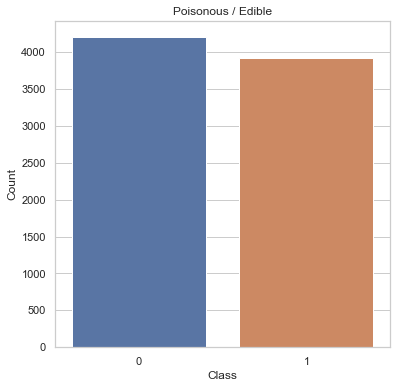

In [6]:
count = df['class'].value_counts()
plt.figure(figsize=(6,6))
sns.barplot(count.index, count.values)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.title('Poisonous / Edible')
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
nn=NeuralNetwork([21,8,1])
nn.fit(X_train,y_train, epochs=100, verbose=True)
nn_p=(nn.predict(X_test) > 0.5).astype(int)
dt=DecisionTree()
dt.fit(X_train,y_train)
dt_p=dt.predict(X_test)

In [8]:
print("Decision Tree Classifier report: \n\n",classification_report(y_test,dt_p))
print("Neural Network (L=8) Classifier report: \n\n",classification_report(y_test,nn_p))

Decision Tree Classifier report: 

               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1283
           1       1.00      0.99      1.00      1155

   micro avg       1.00      1.00      1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438

Neural Network (L=8) Classifier report: 

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1283
           1       1.00      1.00      1.00      1155

   micro avg       1.00      1.00      1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



In [9]:
nn_s, dte_s, dti_s, dtg_s = split_accuracies(65, 100, 5, X, y)

In [10]:
print(nn_s)
print(dte_s)
print(dti_s)
print(dtg_s)

[1.0, 1.0, 0.9926144756277696, 0.9907692307692307, 0.9991796554552912, 0.982779827798278, 0.9975429975429976]
[0.9982419127988749, 0.9995898277276456, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.9989451476793249, 0.9987694831829368, 0.9985228951255539, 1.0, 1.0, 1.0, 1.0]


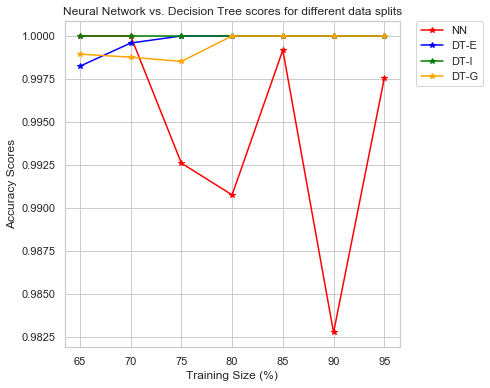

In [11]:
plt.figure(figsize =(6, 6)) 
plt.plot([i for i in range(65, 100,5)], nn_s, marker='*', color = 'red', label='NN')
plt.plot([i for i in range(65, 100,5)], dte_s, marker='*', color = 'blue', label='DT-E')
plt.plot([i for i in range(65, 100,5)], dti_s, marker='*', color = 'green', label='DT-I')
plt.plot([i for i in range(65, 100,5)], dtg_s, marker='*', color = 'orange', label='DT-G')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Training Size (%)')
plt.xticks(np.arange(65,100,5))
plt.ylabel('Accuracy Scores')
plt.title('Neural Network vs. Decision Tree scores for different data splits')
plt.show()

In [12]:
depth_scores = depth_accuracies(X, y)

In [13]:
print(depth_scores)

[[0.5721903199343724, 0.9864643150123051, 0.9864643150123051], [0.6251025430680885, 0.9950779327317474, 0.9889253486464314], [0.716160787530763, 0.9971287940935193, 0.9934372436423298], [0.8941755537325676, 1.0, 0.9979491386382281], [0.9934372436423298, 1.0, 0.9987694831829368], [0.9934372436423298, 1.0, 0.9987694831829368], [0.9934372436423298, 1.0, 0.9987694831829368], [0.994667760459393, 1.0, 0.9987694831829368], [0.9975389663658737, 1.0, 0.9987694831829368], [0.9975389663658737, 1.0, 0.9987694831829368]]


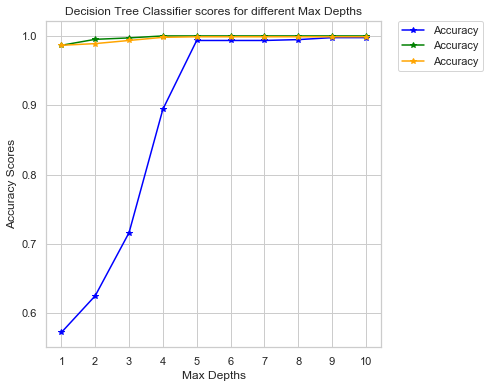

In [15]:
plt.figure(figsize =(6, 6))
e,i,g=[],[],[]
for d in depth_scores:
    e.append(d[0])
    i.append(d[1])
    g.append(d[2])
plt.plot([i for i in range(1,11)], e, marker='*', color = 'blue', label='Accuracy')
plt.plot([i for i in range(1,11)], i, marker='*', color = 'green', label='Accuracy')
plt.plot([i for i in range(1,11)], g, marker='*', color = 'orange', label='Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Max Depths')
plt.xticks(np.arange(1,11,1))
plt.ylabel('Accuracy Scores')
plt.title('Decision Tree Classifier scores for different Max Depths')
plt.show()

In [16]:
print(e)
print(i)
print(g)

[0.5721903199343724, 0.6251025430680885, 0.716160787530763, 0.8941755537325676, 0.9934372436423298, 0.9934372436423298, 0.9934372436423298, 0.994667760459393, 0.9975389663658737, 0.9975389663658737]
[0.9864643150123051, 0.9950779327317474, 0.9971287940935193, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.9864643150123051, 0.9889253486464314, 0.9934372436423298, 0.9979491386382281, 0.9987694831829368, 0.9987694831829368, 0.9987694831829368, 0.9987694831829368, 0.9987694831829368, 0.9987694831829368]


In [17]:
nn_scores = hidden_layer_nodes(X, y)

In [18]:
print(nn_scores)

[0.9934372436423298, 0.9991796554552912, 1.0, 1.0]


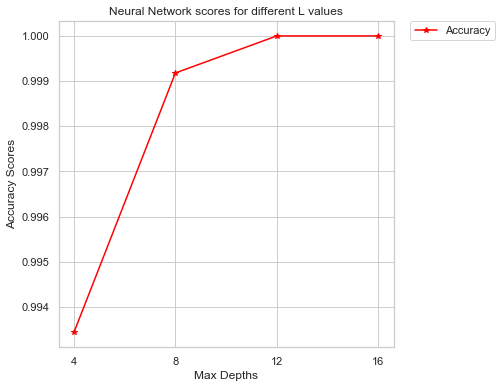

In [19]:
plt.figure(figsize =(6, 6)) 
plt.plot([i for i in [4,8,12,16]], nn_scores, marker='*', color = 'red', label='Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Max Depths')
plt.xticks([4,8,12,16])
plt.ylabel('Accuracy Scores')
plt.title('Neural Network scores for different L values')
plt.show()

In [20]:
nn_scores = learning_rates(X, y)

In [21]:
print(nn_scores)

[0.9356029532403609, 0.9745693191140279, 0.9934372436423298, 0.9991796554552912, 1.0, 0.9991796554552912]


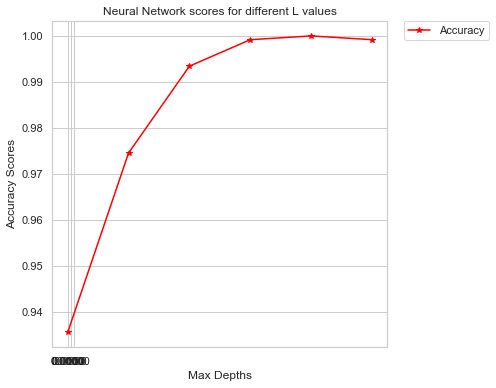

In [22]:
plt.figure(figsize =(6, 6)) 
plt.plot([i for i in range(6)], nn_scores, marker='*', color = 'red', label='Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Max Depths')
plt.xticks([0.0001, 0.001, 0.005, 0.01, 0.05, 0.1])
plt.ylabel('Accuracy Scores')
plt.title('Neural Network scores for different L values')
plt.show()

In [23]:
df = pd.read_csv('data-other/data.csv')
df = df.rename(columns={'left': 'class'})
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,class,promotion_last_5years,sales,salary
0,0.10,0.90,7,286,4,0,1,0,sales,low
1,0.89,0.93,4,249,3,0,0,0,sales,low
2,0.38,0.50,2,132,3,0,1,0,accounting,low
3,0.95,0.71,4,151,4,0,0,0,sales,medium
4,0.84,0.84,5,163,3,0,0,0,technical,low


In [24]:
labelencoder=LabelEncoder()
for column in df.columns:
    df[column] = labelencoder.fit_transform(df[column])
X = df.drop(['class'], axis=1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [26]:
nn=NeuralNetwork([9,8,1])
nn.fit(X_train,y_train, epochs=100, verbose=True)
nn_p=(nn.predict(X_test) > 0.5).astype(int)
dt=DecisionTree()
dt.fit(X_train,y_train)
dt_p=dt.predict(X_test)

In [27]:
print("Decision Tree Classifier report: \n\n",classification_report(y_test,dt_p))
print("Neural Network (L=8) Classifier report: \n\n",classification_report(y_test,nn_p))

Decision Tree Classifier report: 

               precision    recall  f1-score   support

           0       0.94      0.98      0.96      2544
           1       0.92      0.81      0.86       828

   micro avg       0.94      0.94      0.94      3372
   macro avg       0.93      0.89      0.91      3372
weighted avg       0.94      0.94      0.94      3372

Neural Network (L=8) Classifier report: 

               precision    recall  f1-score   support

           0       0.75      1.00      0.86      2544
           1       0.00      0.00      0.00       828

   micro avg       0.75      0.75      0.75      3372
   macro avg       0.38      0.50      0.43      3372
weighted avg       0.57      0.75      0.65      3372



C:\Users\slm\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\slm\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\slm\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [28]:
nn_s, dte_s, dti_s, dtg_s = split_accuracies(65, 100, 5, X, y)

In [29]:
print(nn_s)
print(dte_s)
print(dti_s)
print(dtg_s)

[0.7686832740213523, 0.7704626334519573, 0.7722419928825622, 0.7651245551601423, 0.7591933570581257, 0.7491103202846975, 0.7295373665480427]
[0.9412811387900356, 0.9451364175563464, 0.9476868327402135, 0.9466192170818505, 0.9525504151838672, 0.9537366548042705, 0.9501779359430605]
[0.9273004575495679, 0.9291221826809015, 0.9419928825622775, 0.9417259786476868, 0.9507710557532622, 0.952846975088968, 0.9412811387900356]
[0.9214539908490087, 0.92497034400949, 0.9327402135231316, 0.9297153024911032, 0.9418742586002372, 0.9403914590747331, 0.9252669039145908]


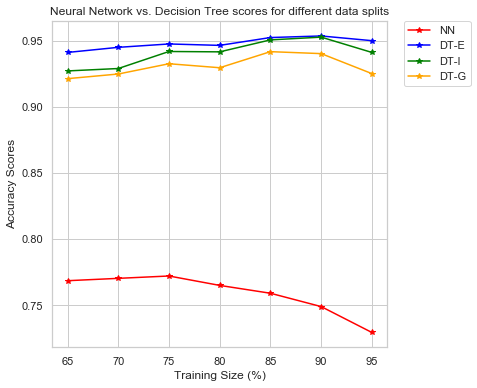

In [30]:
plt.figure(figsize =(6, 6)) 
plt.plot([i for i in range(65, 100,5)], nn_s, marker='*', color = 'red', label='NN')
plt.plot([i for i in range(65, 100,5)], dte_s, marker='*', color = 'blue', label='DT-E')
plt.plot([i for i in range(65, 100,5)], dti_s, marker='*', color = 'green', label='DT-I')
plt.plot([i for i in range(65, 100,5)], dtg_s, marker='*', color = 'orange', label='DT-G')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Training Size (%)')
plt.xticks(np.arange(65,100,5))
plt.ylabel('Accuracy Scores')
plt.title('Neural Network vs. Decision Tree scores for different data splits')
plt.show()

In [31]:
depth_scores = depth_accuracies(X, y)

In [32]:
print(depth_scores)

[[0.8997627520759194, 0.8997627520759194, 0.8997627520759194], [0.9205219454329775, 0.9163701067615658, 0.91073546856465], [0.9460260972716489, 0.9291221826809015, 0.92497034400949], [0.9451364175563464, 0.9291221826809015, 0.92497034400949], [0.9451364175563464, 0.9291221826809015, 0.92497034400949], [0.9451364175563464, 0.9291221826809015, 0.92497034400949], [0.9451364175563464, 0.9291221826809015, 0.92497034400949], [0.9451364175563464, 0.9291221826809015, 0.92497034400949], [0.9451364175563464, 0.9291221826809015, 0.92497034400949], [0.9451364175563464, 0.9291221826809015, 0.92497034400949]]


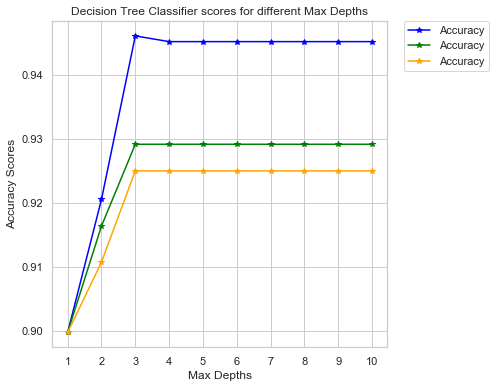

In [34]:
plt.figure(figsize =(6, 6))
e,i,g=[],[],[]
for d in depth_scores:
    e.append(d[0])
    i.append(d[1])
    g.append(d[2])
plt.plot([i for i in range(1,11)], e, marker='*', color = 'blue', label='Accuracy')
plt.plot([i for i in range(1,11)], i, marker='*', color = 'green', label='Accuracy')
plt.plot([i for i in range(1,11)], g, marker='*', color = 'orange', label='Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Max Depths')
plt.xticks(np.arange(1,11,1))
plt.ylabel('Accuracy Scores')
plt.title('Decision Tree Classifier scores for different Max Depths')
plt.show()

In [35]:
nn_scores = hidden_layer_nodes(X, y)

Epoch: 20/100

C:\Users\slm\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


In [36]:
print(nn_scores)

[0.7704626334519573, 0.7704626334519573, 0.7701660735468565, 0.7704626334519573]


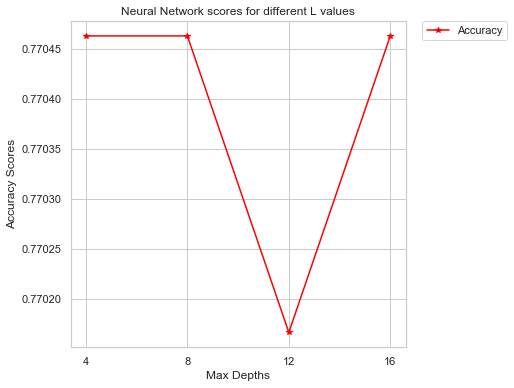

In [37]:
plt.figure(figsize =(6, 6)) 
plt.plot([i for i in [4,8,12,16]], nn_scores, marker='*', color = 'red', label='Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Max Depths')
plt.xticks([4,8,12,16])
plt.ylabel('Accuracy Scores')
plt.title('Neural Network scores for different L values')
plt.show()

In [38]:
nn_scores = learning_rates(X, y)

Epoch: 75/1000

C:\Users\slm\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


In [39]:
print(nn_scores)

[0.7704626334519573, 0.9486951364175563, 0.9074733096085409, 0.8380782918149466, 0.7704626334519573, 0.7704626334519573]


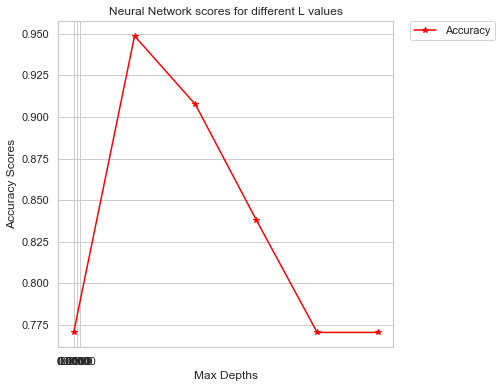

In [40]:
plt.figure(figsize =(6, 6)) 
plt.plot([i for i in range(6)], nn_scores, marker='*', color = 'red', label='Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Max Depths')
plt.xticks([0.0001, 0.001, 0.005, 0.01, 0.05, 0.1])
plt.ylabel('Accuracy Scores')
plt.title('Neural Network scores for different L values')
plt.show()

In [41]:
df = pd.read_csv('data/banknote.csv')
df = df.rename(columns={'class': 'class'})
df.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


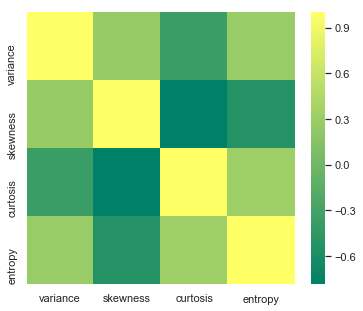

In [42]:
correlations = df.drop(columns=['class']).corr()
plt.figure(figsize=(6,5))
sns.heatmap(correlations,cmap='summer')

0    762
1    610
Name: class, dtype: int64


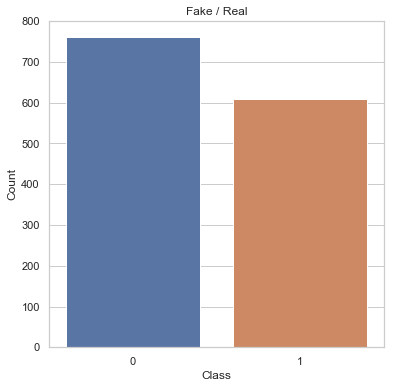

In [43]:
print(df['class'].value_counts())
count = df['class'].value_counts()
plt.figure(figsize=(6,6))
sns.barplot(count.index, count.values)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.title('Fake / Real')
plt.show()

In [44]:
labelencoder=LabelEncoder()
for column in df.columns:
    df[column] = labelencoder.fit_transform(df[column])
X = df.drop(['class'], axis=1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [45]:
nn=NeuralNetwork([X.shape[1],8,1])
nn.fit(X_train,y_train, epochs=100, verbose=True)
nn_p=(nn.predict(X_test) > 0.5).astype(int)
dt=DecisionTree()
dt.fit(X_train,y_train)
dt_p=dt.predict(X_test)

Epoch: 1/100

C:\Users\slm\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


In [46]:
print("Decision Tree Classifier report: \n\n",classification_report(y_test,dt_p))
print("Neural Network (L=8) Classifier report: \n\n",classification_report(y_test,nn_p))

Decision Tree Classifier report: 

               precision    recall  f1-score   support

           0       0.56      1.00      0.72       229
           1       1.00      0.01      0.01       183

   micro avg       0.56      0.56      0.56       412
   macro avg       0.78      0.50      0.36       412
weighted avg       0.75      0.56      0.40       412

Neural Network (L=8) Classifier report: 

               precision    recall  f1-score   support

           0       0.68      0.97      0.80       229
           1       0.92      0.44      0.59       183

   micro avg       0.73      0.73      0.73       412
   macro avg       0.80      0.70      0.70       412
weighted avg       0.79      0.73      0.71       412



In [47]:
nn_s, dte_s, dti_s, dtg_s = split_accuracies(65, 100, 5, X, y)

Epoch: 1/100

C:\Users\slm\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


In [48]:
print(nn_s)
print(dte_s)
print(dti_s)
print(dtg_s)

[0.5717255717255717, 0.5631067961165048, 0.685131195335277, 0.7454545454545455, 0.5679611650485437, 0.6159420289855072, 0.6086956521739131]
[0.5613305613305614, 0.5631067961165048, 0.5685131195335277, 0.5709090909090909, 0.5776699029126213, 0.5652173913043478, 0.5507246376811594]
[0.5613305613305614, 0.5631067961165048, 0.5685131195335277, 0.5709090909090909, 0.5776699029126213, 0.5652173913043478, 0.5507246376811594]
[0.5613305613305614, 0.5631067961165048, 0.5685131195335277, 0.5709090909090909, 0.5776699029126213, 0.5652173913043478, 0.5507246376811594]


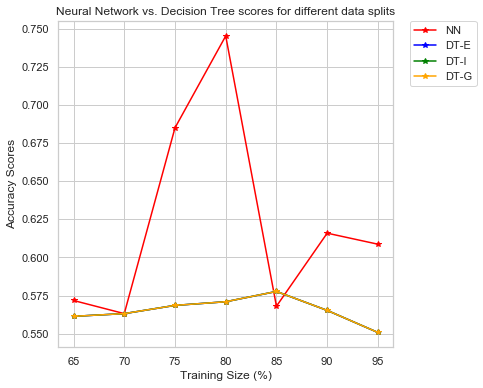

In [49]:
plt.figure(figsize =(6, 6)) 
plt.plot([i for i in range(65, 100,5)], nn_s, marker='*', color = 'red', label='NN')
plt.plot([i for i in range(65, 100,5)], dte_s, marker='*', color = 'blue', label='DT-E')
plt.plot([i for i in range(65, 100,5)], dti_s, marker='*', color = 'green', label='DT-I')
plt.plot([i for i in range(65, 100,5)], dtg_s, marker='*', color = 'orange', label='DT-G')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Training Size (%)')
plt.xticks(np.arange(65,100,5))
plt.ylabel('Accuracy Scores')
plt.title('Neural Network vs. Decision Tree scores for different data splits')
plt.show()

In [50]:
depth_scores = depth_accuracies(X, y)

In [51]:
print(depth_scores)

[[0.5631067961165048, 0.5631067961165048, 0.5631067961165048], [0.5631067961165048, 0.5631067961165048, 0.5631067961165048], [0.5631067961165048, 0.5631067961165048, 0.5631067961165048], [0.5631067961165048, 0.5631067961165048, 0.5631067961165048], [0.5631067961165048, 0.5631067961165048, 0.5631067961165048], [0.5631067961165048, 0.5631067961165048, 0.5631067961165048], [0.5631067961165048, 0.5631067961165048, 0.5631067961165048], [0.5631067961165048, 0.5631067961165048, 0.5631067961165048], [0.5631067961165048, 0.5631067961165048, 0.5631067961165048], [0.5631067961165048, 0.5631067961165048, 0.5631067961165048]]


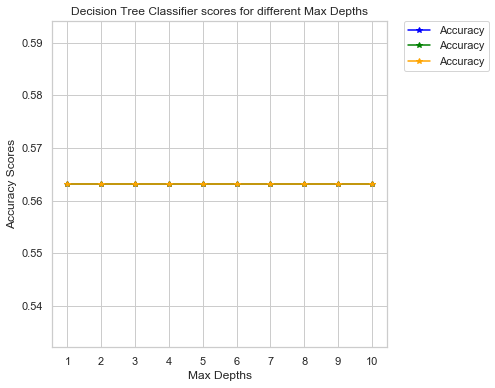

In [53]:
plt.figure(figsize =(6, 6))
e,i,g=[],[],[]
for d in depth_scores:
    e.append(d[0])
    i.append(d[1])
    g.append(d[2])
plt.plot([i for i in range(1,11)], e, marker='*', color = 'blue', label='Accuracy')
plt.plot([i for i in range(1,11)], i, marker='*', color = 'green', label='Accuracy')
plt.plot([i for i in range(1,11)], g, marker='*', color = 'orange', label='Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Max Depths')
plt.xticks(np.arange(1,11,1))
plt.ylabel('Accuracy Scores')
plt.title('Decision Tree Classifier scores for different Max Depths')
plt.show()

In [54]:
nn_scores = hidden_layer_nodes(X, y)

Epoch: 1/100

C:\Users\slm\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


In [55]:
print(nn_scores)

[0.5631067961165048, 0.6140776699029126, 0.662621359223301, 0.6432038834951457]


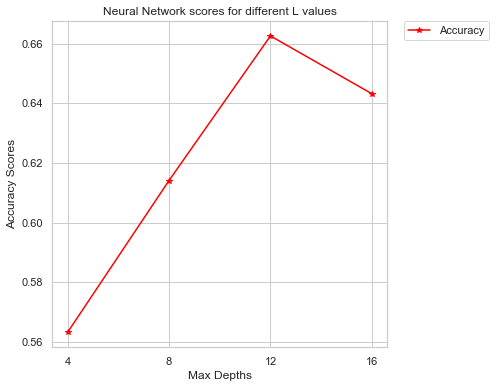

In [56]:
plt.figure(figsize =(6, 6)) 
plt.plot([i for i in [4,8,12,16]], nn_scores, marker='*', color = 'red', label='Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Max Depths')
plt.xticks([4,8,12,16])
plt.ylabel('Accuracy Scores')
plt.title('Neural Network scores for different L values')
plt.show()

In [57]:
nn_scores = learning_rates(X, y)

Epoch: 1/1000

C:\Users\slm\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


In [58]:
print(nn_scores)

[0.8519417475728155, 0.8033980582524272, 0.8470873786407767, 0.7524271844660194, 0.5606796116504854, 0.5631067961165048]


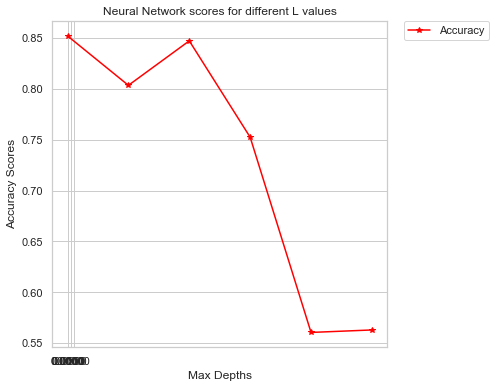

In [59]:
plt.figure(figsize =(6, 6)) 
plt.plot([i for i in range(6)], nn_scores, marker='*', color = 'red', label='Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Max Depths')
plt.xticks([0.0001, 0.001, 0.005, 0.01, 0.05, 0.1])
plt.ylabel('Accuracy Scores')
plt.title('Neural Network scores for different L values')
plt.show()